In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc
from scipy import stats

# Binary Logistic regression : between sleep factors and CN / non-CN

### 데이터 전처리
* sleep 관련 속성들과 DIAG_NM의 속성을 CN: 0, non-CN: 1로 치환하여 dataframe 생성

In [77]:
from imblearn.over_sampling import SMOTE
from collections import Counter

data = pd.read_excel("dataset_added.xlsx")

#sleep 관련 변수 필터링
sleep_cols = [col for col in data.columns if 'sleep_' in col.lower()]
sleep_data = data[sleep_cols]

x_bin = sleep_data

mapping = {'CN': 0, 'MCI': 1, 'Dem': 1}
data['DIAG_NM_numeric'] = data['DIAG_NM'].map(mapping)
y_bin = data['DIAG_NM_numeric']

# 오버샘플링 수행
smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(x_bin, y_bin)

# # NumPy 배열로 반환된 결과를 DataFrame으로 변환 (X_train이 DataFrame일 때)
# if isinstance(x_bin, pd.DataFrame):
#     X_res = pd.DataFrame(x_res, columns=x_bin.columns)
#     Y_res = pd.Series(y_res, name=y_bin.name)

# 클래스 비율 확인
print("Resampled class distribution with SMOTE:", Counter(y_res))

# Resampled 데이터를 DataFrame으로 변환
smote_df = pd.DataFrame(x_res, columns=x_bin.columns)
smote_df['DIAG_NM_numeric'] = y_res

#new_df_bin = pd.concat([x_bin, y_bin], axis=1)


Resampled class distribution with SMOTE: Counter({1: 111, 0: 111})


### test-set, train-set 분리

In [78]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(smote_df.iloc[:,:-1], 
                                                    smote_df.iloc[:,-1], 
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    stratify=smote_df['DIAG_NM_numeric'])

print("The dimension of the trainset is ", x_train.shape)
print("The dimension of the testset is ", x_test.shape)
print(y_train.value_counts(normalize=True))

The dimension of the trainset is  (155, 26)
The dimension of the testset is  (67, 26)
DIAG_NM_numeric
0    0.503226
1    0.496774
Name: proportion, dtype: float64


In [79]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scaler = StandardScaler()
xtrain_scaled = scaler.fit_transform(x_train)
xtest_scaled = scaler.fit_transform(x_test)

### Training with Logistic regression

In [80]:
from sklearn.linear_model import LogisticRegression

model1 = LogisticRegression(tol=1e-08).fit(xtrain_scaled, y_train)
coef = {}
i = 0
for col in x_bin.columns:
    coef.setdefault(col,model1.coef_[0][i])
    i += 1
print("_____________________________________________")
print("regression coefficients are ", coef)
print("inpercept is ", model1.intercept_)
print("model score is ", model1.score(xtrain_scaled, y_train))
print("_____________________________________________")

_____________________________________________
regression coefficients are  {'sleep_awake': np.float64(0.18139072090582395), 'sleep_breath_average': np.float64(0.12531734343158787), 'sleep_deep': np.float64(-0.09240168339244906), 'sleep_duration': np.float64(0.4601774046220855), 'sleep_efficiency': np.float64(-0.03628015236002518), 'sleep_hr_average': np.float64(-0.29478846910829126), 'sleep_hr_lowest': np.float64(0.10014011479657772), 'sleep_light': np.float64(0.5300618582789681), 'sleep_midpoint_at_delta': np.float64(-0.23111882294940975), 'sleep_midpoint_time': np.float64(-0.4067050281027598), 'sleep_onset_latency': np.float64(-0.07562973034458681), 'sleep_period_id': np.float64(0.07994866717260782), 'sleep_rem': np.float64(0.09772103526142396), 'sleep_restless': np.float64(-0.004814112284939308), 'sleep_rmssd': np.float64(-0.44661398986335027), 'sleep_score': np.float64(-0.15175030099320366), 'sleep_score_alignment': np.float64(0.4693019767822191), 'sleep_score_deep': np.float64(-0.

In [81]:
y_pred = model1.predict(xtest_scaled)
print("predicted DIAG_NMs are ", y_pred)

predicted DIAG_NMs are  [1 1 0 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 1
 0 0 0 1 0 0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 0 0]


[[18 15]
 [16 18]]


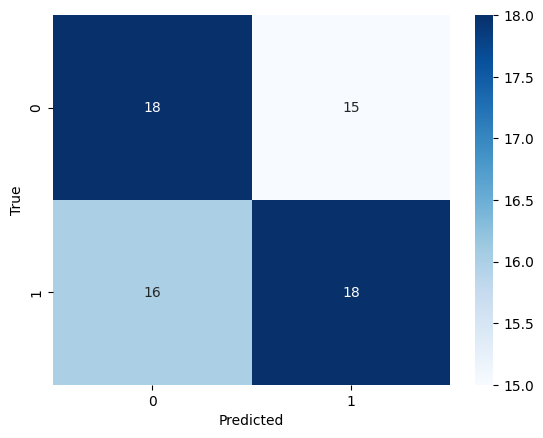

In [82]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [83]:
print(metrics.classification_report(y_test, y_pred, target_names=['CN', 'non-CN']))

              precision    recall  f1-score   support

          CN       0.53      0.55      0.54        33
      non-CN       0.55      0.53      0.54        34

    accuracy                           0.54        67
   macro avg       0.54      0.54      0.54        67
weighted avg       0.54      0.54      0.54        67



# dataset_added에서 statsmodel.Logit 활용한 Nan 많이 나오는 summary()

In [84]:
from imblearn.over_sampling import SMOTE
from collections import Counter

data = pd.read_excel("dataset_added.xlsx")

#sleep 관련 변수 필터링
sleep_cols = [col for col in data.columns if 'sleep_' in col.lower()]
sleep_data = data[sleep_cols]

x_bin = sleep_data

mapping = {'CN': 0, 'MCI': 1, 'Dem': 1}
data['DIAG_NM_numeric'] = data['DIAG_NM'].map(mapping)
y_bin = data['DIAG_NM_numeric']

# 오버샘플링 수행
smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(x_bin, y_bin)

# Resampled 데이터를 DataFrame으로 변환
smote_df = pd.DataFrame(x_res, columns=x_bin.columns)
smote_df['DIAG_NM_numeric'] = y_res

# X에 상수항 추가
x_with_const_og = sm.add_constant(x_res.iloc[:,:-1])
# 4. statsmodels로 p-value 계산
sm_logit_model = sm.Logit(y_res, x_with_const_og)
result = sm_logit_model.fit()

# 5. 결과 출력
print(result.summary())

         Current function value: 0.586918
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:        DIAG_NM_numeric   No. Observations:                  222
Model:                          Logit   Df Residuals:                      197
Method:                           MLE   Df Model:                           24
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                  0.1533
Time:                        15:22:51   Log-Likelihood:                -130.30
converged:                      False   LL-Null:                       -153.88
Covariance Type:            nonrobust   LLR p-value:                  0.003197
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -38.0751     36.515     -1.043      0.297    -109.643      33.493
sleep_awake   

/Users/raewookang/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# dataset_added에서 다중공선성 보이는 독립변수 확인

In [85]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

og_data = pd.read_excel("dataset_added.xlsx")
vif_data_og = pd.DataFrame()
vif_data_og["feature"] = x_with_const_og.columns
vif_data_og["VIF"] = [variance_inflation_factor(x_with_const_og.values, i) for i in range(x_with_const_og.shape[1])]

vif_data_og

/Users/raewookang/Library/Python/3.9/lib/python/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,5.918182e+04
1,sleep_awake,inf
2,sleep_breath_average,1.433966e+00
3,sleep_deep,inf
4,sleep_duration,inf
5,sleep_efficiency,8.012138e+02
6,sleep_hr_average,3.777364e+01
7,sleep_hr_lowest,4.031639e+01
8,sleep_light,inf
9,sleep_midpoint_at_delta,2.243946e+00


In [86]:
vif_above_five = []
for row in vif_data_og.iterrows():
    if row[1]["VIF"] != "inf" and row[1]["VIF"] < 5:
        vif_above_five.append(row[1])
for i in vif_above_five:
    print(i["feature"],"\t",i["VIF"])

sleep_breath_average 	 1.4339664844359492
sleep_midpoint_at_delta 	 2.243945906071945
sleep_onset_latency 	 1.6506902037144648
sleep_period_id 	 1.237040285022134
sleep_rmssd 	 1.8318714053170018


### 다중공선성 확인 및 제거한 데이터를 기반으로 추출한 statsmodel.Logit()

In [87]:
from imblearn.over_sampling import SMOTE
from collections import Counter

del_data = pd.read_excel("dataset_added_deleted.xlsx")

#sleep 관련 변수 필터링
sleep_cols = [col for col in del_data.columns if 'sleep_' in col.lower()]
sleep_data = del_data[sleep_cols]

x_bin = sleep_data

mapping = {'CN': 0, 'MCI': 1, 'Dem': 1}
del_data['DIAG_NM_numeric'] = del_data['DIAG_NM'].map(mapping)
y_bin = del_data['DIAG_NM_numeric']

# 오버샘플링 수행
smote = SMOTE(random_state=42)
x_res, y_res = smote.fit_resample(x_bin, y_bin)

# Resampled 데이터를 DataFrame으로 변환
smote_df = pd.DataFrame(x_res, columns=x_bin.columns)
smote_df['DIAG_NM_numeric'] = y_res

# X에 상수항 추가
x_with_const = sm.add_constant(x_res.iloc[:,:])

# 4. statsmodels로 p-value 계산
sm_logit_model = sm.Logit(y_res, x_with_const)
result = sm_logit_model.fit()

# 5. 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.685176
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:        DIAG_NM_numeric   No. Observations:                  222
Model:                          Logit   Df Residuals:                      216
Method:                           MLE   Df Model:                            5
Date:                Wed, 11 Dec 2024   Pseudo R-squ.:                 0.01150
Time:                        15:22:51   Log-Likelihood:                -152.11
converged:                       True   LL-Null:                       -153.88
Covariance Type:            nonrobust   LLR p-value:                    0.6175
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.9099      2.457     -0.777      0.437      -6.726   